In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import random
random.seed(42)


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import gc
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage. 
        # Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage       
    """
    import numpy as np

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [4]:
df_train = pd.read_csv('train_V2.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [5]:
df_train = reduce_mem_usage(df_train)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory usage: 288.4+ MB


In [7]:
pd.set_option('display.max_columns', 500)

In [8]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [9]:
df_test = pd.read_csv('test_V2.csv')

In [11]:
df_test = reduce_mem_usage(df_test)

In [12]:
#Removing NAN values from the dataset
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [13]:
df_train.dropna(inplace=True)

In [14]:
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [16]:
print(len(df_train))
print(len(df_test))

4446965
1934174


# visualizations and Removing Outliers

In [17]:
def visualization (col, num_bin=10):
    title = col[0].upper() + col[1:]
    f,axes=plt.subplots()
    plt.xlabel(title)
    plt.ylabel('Log Count')
    axes.set_yscale('log')
    df_train.hist(column=col,ax=axes,bins=num_bin)
    plt.title('Histogram of ' + title)
    plt.show()
    
    tmp = df_train[col].value_counts().sort_values(ascending=False)

    print('Min value of ' + title + ' is: ',min(tmp.index))
    print('Max value of ' + title + ' is: ',max(tmp.index))

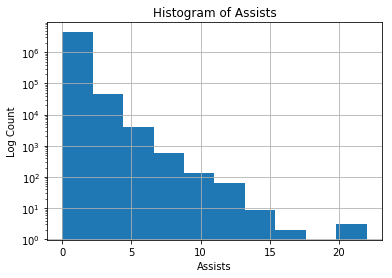

Min value of Assists is:  0
Max value of Assists is:  22


In [21]:
 visualization('assists')

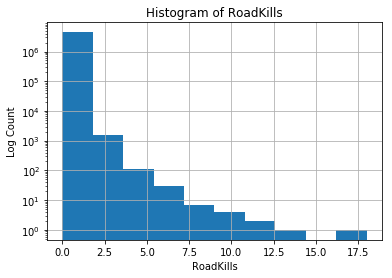

Min value of RoadKills is:  0
Max value of RoadKills is:  18


In [22]:
visualization('roadKills')

In [18]:
# # since, most of the players have kills from  0 to 10 
# so to remove the outliers from my data, we drop all the players who have more than 10 roadkills.
 # drop all the road kills above 10.


#test

df_train.drop(df_train[df_train['roadKills']>=10].index,inplace=True)

#test 

df_test.drop(df_test[df_test['roadKills']>=10].index,inplace=True)


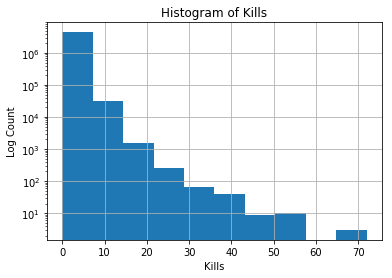

Min value of Kills is:  0
Max value of Kills is:  72


In [57]:
visualization('kills')

In [19]:
 # dropping the outliers.

#train
df_train.drop(df_train[df_train['kills']>=35].index,inplace=True)

#test

df_test.drop(df_test[df_test['kills']>=35].index,inplace=True)

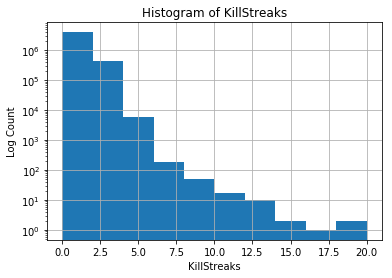

Min value of KillStreaks is:  0
Max value of KillStreaks is:  20


In [23]:
 visualization('killStreaks')

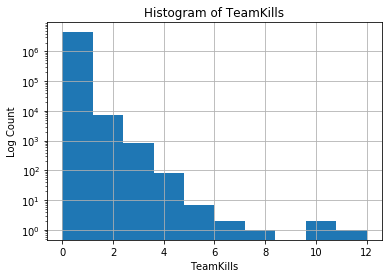

Min value of TeamKills is:  0
Max value of TeamKills is:  12


In [32]:
visualization('teamKills')

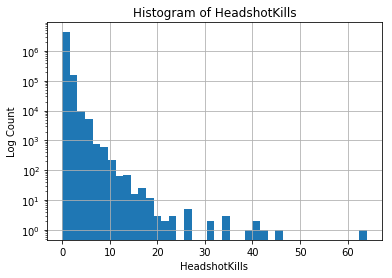

Min value of HeadshotKills is:  0
Max value of HeadshotKills is:  64


In [33]:
visualization('headshotKills', num_bin=40)

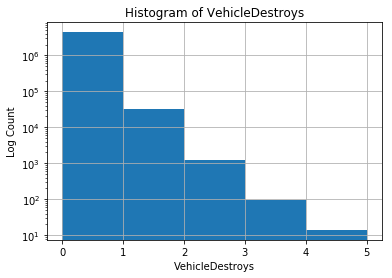

Min value of VehicleDestroys is:  0
Max value of VehicleDestroys is:  5


In [34]:
 visualization('vehicleDestroys',num_bin=5)

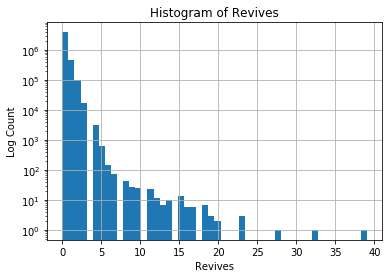

Min value of Revives is:  0
Max value of Revives is:  39


In [35]:
visualization('revives',num_bin=50) 

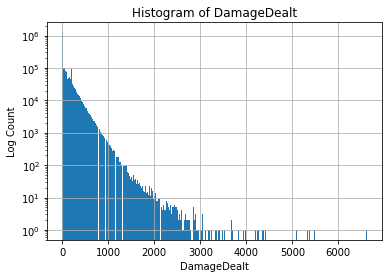

Min value of DamageDealt is:  0.0
Max value of DamageDealt is:  6616.0


In [38]:
visualization('damageDealt', num_bin=1000)

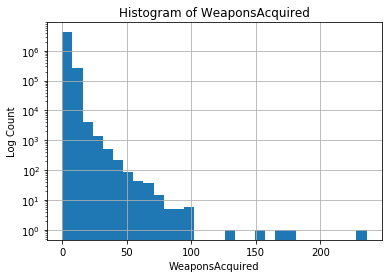

Min value of WeaponsAcquired is:  0
Max value of WeaponsAcquired is:  236


In [39]:
visualization('weaponsAcquired',num_bin=30)

In [20]:
 # removing the outliers.

#train
df_train.drop(df_train[df_train.weaponsAcquired>=50].index,inplace=True)

#test
df_test.drop(df_test[df_test.weaponsAcquired>=50].index,inplace=True)

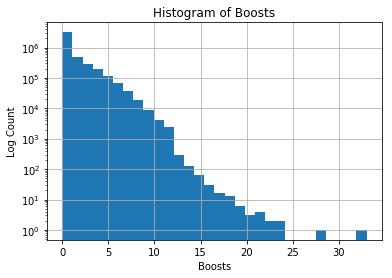

Min value of Boosts is:  0
Max value of Boosts is:  33


In [40]:
visualization('boosts',num_bin=30)

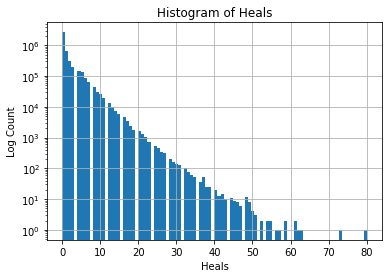

Min value of Heals is:  0
Max value of Heals is:  80


In [41]:
visualization('heals', num_bin=100)

In [21]:
 # removing the outliers.

#train
df_train.drop(df_train[df_train.heals>=40].index,inplace=True)

#test

df_test.drop(df_test[df_test.heals>=40].index,inplace=True)

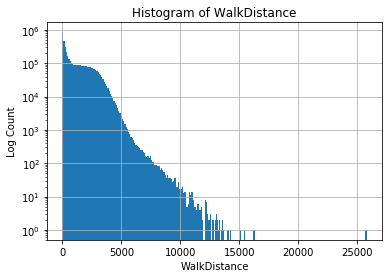

Min value of WalkDistance is:  0.0
Max value of WalkDistance is:  25776.0


In [42]:
visualization('walkDistance',num_bin=250)

In [22]:
 #Removing the outliers

#train
df_train.drop(df_train[df_train['walkDistance']>=10000].index,inplace=True)


#test
df_test.drop(df_test[df_test['walkDistance']>=10000].index,inplace=True)

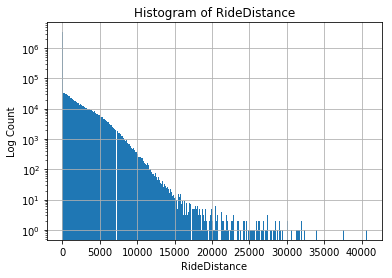

Min value of RideDistance is:  0.0
Max value of RideDistance is:  40704.0


In [43]:
visualization('rideDistance',num_bin=500)

In [23]:
 #Removing the outliers.

#test

df_train.drop(df_train[df_train.rideDistance >=15000].index, inplace=True)

#test

df_test.drop(df_test[df_test.rideDistance >=15000].index, inplace=True)

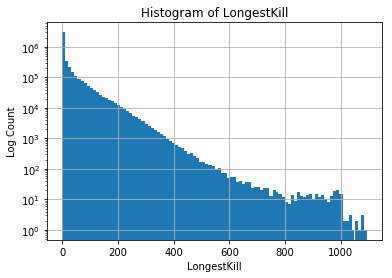

Min value of LongestKill is:  0.0
Max value of LongestKill is:  1094.0


In [49]:
visualization('longestKill', num_bin=100) 

 Most kills are made from a distance of 100 meters or closer. There are however some outliers who make a kill from more than 1km away. This is probably done by cheaters or game crackers. 

In [24]:
# drop outliers.      


#train
df_train.drop(df_train[df_train['longestKill']>=1000].index,inplace=True)

#test

df_test.drop(df_test[df_test['longestKill']>=1000].index,inplace=True)

In [25]:
df_train.shape

(4445866, 29)

 So the initial shape is (4446965, 29)And After removing the outliers the new shape is  (4445866, -) 
 Something around 1100 rows have been removed until now. Which is nothing compared to the number of rows we have.

In [66]:
#So the initial shape is (4446965, 29)And After removing the outliers the new shape is (4445866, -) 
#Something around 1100 rows have been removed until now. Which is nothing compared to the number of rows we have.

In [26]:
# Creating a dummy variable for categorical variable present in our data set.
#matchType
#train

df_train=pd.get_dummies(df_train,columns=['matchType'])

#test

df_test=pd.get_dummies(df_test,columns=['matchType'])

In [30]:
#Correlation Analysis
cols_to_drop = ['Id','matchId','groupId','matchType']
cols_to_fit = [col for col in df_train.columns if col not in cols_to_drop]
corr = df_train[cols_to_fit].corr()

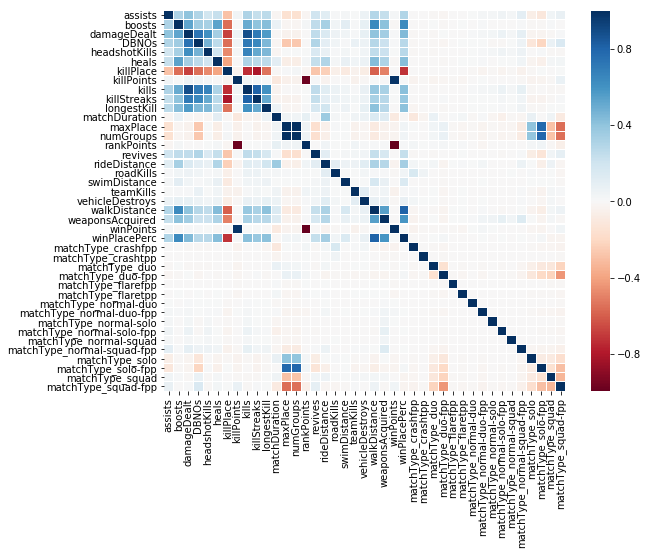

In [31]:
plt.figure(figsize=(9,7))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,linecolor='white',linewidths=0.1,cmap='RdBu')
plt.show()

In [32]:
t = df_train
t =t.drop(['Id','groupId','matchId',],axis=1)
y = t['winPlacePerc']
X = t.drop(['winPlacePerc'],axis=1)
X_test = df_test.drop(['Id','groupId','matchId'],axis=1)

In [34]:
#splitting the data into training and testing by using train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7)
len(X_train)

del train,test,X,y

#X_train = X
#y_train = y
gc.collect()

# Model LightGBM

In [38]:
import lightgbm as lgbm

In [36]:
def calculate_error(cl,name):
  print(name)
  y_pre = cl.predict(X_val)
  print('Mean Absolute Error is {:.5f}'.format(mean_absolute_error(y_val,y_pre)))
  print('R2 score is {:.2%}'.format(r2_score(y_val, cl.predict(X_val))))

In [42]:
# Create parameters to search
params = {"objective" : "regression", "metric" : "mae", 'n_estimators':20000, 
              'early_stopping_rounds':200, "num_leaves" : 31, "learning_rate" : 0.05, 
              "bagging_fraction" : 0.7, "bagging_seed" : 0, "num_threads" : 4,
              "colsample_bytree" : 0.7
             }
lgbTrain = lgbm.Dataset(X_train, label=y_train)
lgbVal = lgbm.Dataset(X_val, label=y_val)
model = lgbm.train(params,lgbTrain,valid_sets=[lgbTrain, lgbVal],
                      early_stopping_rounds=200, verbose_eval=1000)


F:\Softwares\PythonWithanaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
F:\Softwares\PythonWithanaconda\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 0.0565392	valid_1's l1: 0.0567965
[2000]	training's l1: 0.0558101	valid_1's l1: 0.0562844
[3000]	training's l1: 0.0553457	valid_1's l1: 0.056017
[4000]	training's l1: 0.0549721	valid_1's l1: 0.0558226
[5000]	training's l1: 0.0546162	valid_1's l1: 0.0556425
[6000]	training's l1: 0.0543008	valid_1's l1: 0.0554973
[7000]	training's l1: 0.0540163	valid_1's l1: 0.0553766
[8000]	training's l1: 0.0537518	valid_1's l1: 0.0552754
[9000]	training's l1: 0.053508	valid_1's l1: 0.0551922
[10000]	training's l1: 0.0532594	valid_1's l1: 0.0550999
[11000]	training's l1: 0.0530345	valid_1's l1: 0.0550279
[12000]	training's l1: 0.0528079	valid_1's l1: 0.0549512
[13000]	training's l1: 0.0526055	valid_1's l1: 0.0548926
[14000]	training's l1: 0.0523852	valid_1's l1: 0.0548318
[15000]	training's l1: 0.0521787	valid_1's l1: 0.0547781
[16000]	training's l1: 0.0519805	valid_1's l1: 0.0547255
[17000]	training's l1: 0.0518046	val

In [45]:
calculate_error(model,"LGBM")

LGBM
Mean Absolute Error is 0.05455
R2 score is 93.75%


In [47]:
y_predict = model.predict(X_test)

In [52]:
y_predict[y_predict > 1] = 1
y_predict[y_predict < 0] = 0
df_test['winPlacePerc'] = y_predict
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('Finalsubmission.csv', index=False)

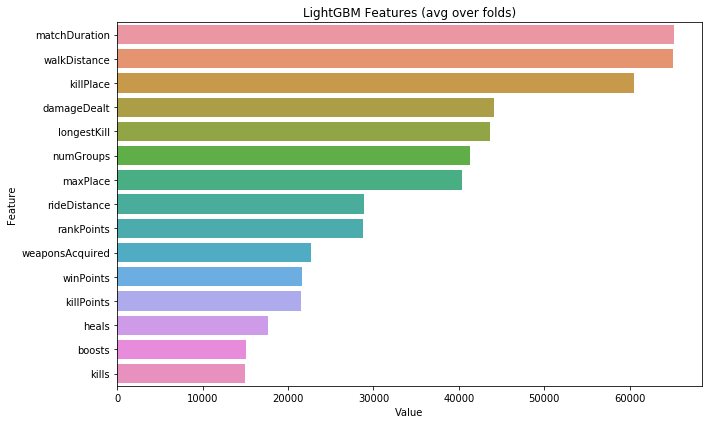

In [55]:
#find which feature importance
cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
cols_to_fit = [col for col in X_train.columns if col not in cols_to_drop]
feature_importance = pd.DataFrame(sorted(zip(model.feature_importance(), cols_to_fit)), columns=['Value','Feature'])
feature_importance = feature_importance.tail(15)


plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig("lgbmfeatures.png",dpi=500)

# Regression Models

In [57]:
def runAllModels(X_train, Y_train):
        
    linear = LinearRegression(copy_X=True)
    linear.fit(X_train,Y_train)
    calculate_error(linear,"linear")

    ridge = Ridge(copy_X=True)
    ridge.fit(X_train,Y_train)
    calculate_error(ridge,"ridge")
    
    lasso = Lasso(copy_X=True)
    lasso.fit(X_train,Y_train)
    calculate_error(lasso,"lasso")
    
    elastic = ElasticNet(copy_X=True)
    elastic.fit(X_train,Y_train)
    calculate_error(elastic,"elastic")
    
    ada = AdaBoostRegressor(learning_rate=0.8)
    ada.fit(X_train,Y_train)
    calculate_error(ada,"Adaboost")
    
    GBR = GradientBoostingRegressor(learning_rate=0.8)
    GBR.fit(X_train,Y_train)
    calculate_error(GBR,"GBR")

    forest = RandomForestRegressor(n_estimators=10)
    forest.fit(X_train,Y_train)
    calculate_error(forest,"forest")
    
    tree = DecisionTreeRegressor()
    tree.fit(X_train,Y_train)
    calculate_error(tree,"tree")

In [58]:
runAllModels(X_train,y_train)

linear
Mean Absolute Error is 0.08977
R2 score is 84.04%
ridge
Mean Absolute Error is 0.08977
R2 score is 84.04%
lasso
Mean Absolute Error is 0.12083
R2 score is 74.53%
elastic
Mean Absolute Error is 0.11297
R2 score is 77.17%
Adaboost
Mean Absolute Error is 0.09976
R2 score is 81.58%
GBR
Mean Absolute Error is 0.06176
R2 score is 92.21%
forest
Mean Absolute Error is 0.06063
R2 score is 92.26%
tree
Mean Absolute Error is 0.08118
R2 score is 85.64%
